In [2]:
import json
import re
from collections import defaultdict, Counter
import os
import pandas as pd

## Humanistic Buddhism Corpus (HBC)

In [3]:
# Define paths
raw_dir = "../data/raw"
processed_dir = "../data/processed"


# Combine JSON files
file_names = [
    os.path.join(raw_dir, "dev.json"),
    os.path.join(raw_dir, "test.json"),
    os.path.join(raw_dir, "train.json")
]

combined_data = []
for file_name in file_names:
    with open(file_name, "r", encoding="utf-8") as file:
        data = json.load(file)
        combined_data.extend(data)

# Save combined data
combined_output_path = os.path.join(processed_dir, "HBC_combined.json")
with open(combined_output_path, "w", encoding="utf-8") as combined_file:
    json.dump(combined_data, combined_file, ensure_ascii=False, indent=2)

print(f"Combined JSON saved at {combined_output_path}")

Combined JSON saved at ../data/processed/HBC_combined.json


In [5]:
combined_file_path = os.path.join(processed_dir, "HBC_combined.json")

with open(combined_file_path, "r", encoding="utf-8") as file:
    HBC_combined_data = json.load(file)

In [7]:
top_10_words = ["法", "心", "佛", "禪", "僧", "空", "覺", "梵", "善", "定"]

# Define paths
prefix_suffix_dir = "../data/processed/prefix_suffix"
output_file_path = "../data/processed/HBC_contexts_ordered.json"

HBC_contexts = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

# Process only the *_prefix.txt and *_suffix.txt files for the top 10 words
for filename in os.listdir(prefix_suffix_dir):
    if "_" in filename and (filename.endswith("_prefix.txt") or filename.endswith("_suffix.txt")):
        character = filename.split("_")[0]  # Get the main character
        if character in top_10_words:  # Only process the top 10 words
            prefix_or_suffix = filename.split("_")[1].replace(".txt", "")  # Determine if it's prefix or suffix
            with open(os.path.join(prefix_suffix_dir, filename), "r", encoding="utf-8") as file:
                terms = [line.strip() for line in file if line.strip()]  # Remove empty lines
                if terms:
                    for term in terms:
                        HBC_contexts[character][f"{character}_{prefix_or_suffix}"][term] = []

# Search each sentence and record context
for entry in HBC_combined_data:
    sentence = entry[0]  # Extract the Chinese sentence (adjust if JSON structure changes)
    for character, context_dict in HBC_contexts.items():
        for prefix_or_suffix, terms_dict in context_dict.items():
            for term in terms_dict.keys():
                if term in sentence:
                    HBC_contexts[character][prefix_or_suffix][term].append(sentence)

# Reorder HBC_contexts by top_10_words and ensure prefix comes before suffix
ordered_HBC_contexts = {}
for character in top_10_words:
    if character in HBC_contexts:
        sorted_dict = {k: HBC_contexts[character][k] for k in sorted(HBC_contexts[character].keys(), key=lambda x: (1 if "prefix" in x else 2))}
        ordered_HBC_contexts[character] = sorted_dict

# Save the ordered result as JSON
with open(output_file_path, "w", encoding="utf-8") as outfile:
    json.dump(ordered_HBC_contexts, outfile, ensure_ascii=False, indent=2)

print(f"Contexts have been successfully saved as {output_file_path}")

Contexts have been successfully saved as ../data/processed/HBC_contexts_ordered.json


In [9]:
# Define paths
prefix_suffix_dir = "../data/processed/prefix_suffix"

word_frequencies = defaultdict(Counter)

# Process only the *_prefix.txt and *_suffix.txt files for the top 10 words
for filename in os.listdir(prefix_suffix_dir):
    if filename.endswith("_prefix.txt") or filename.endswith("_suffix.txt"):
        character = filename.split("_")[0]  # Get the main character
        if character in top_10_words:  # Only process the top 10 words
            position = f"{character}_" if filename.endswith("_prefix.txt") else f"_{character}"
            
            # Read two-character terms and initialize them with frequency 0
            with open(os.path.join(prefix_suffix_dir, filename), "r", encoding="utf-8") as file:
                terms = [line.strip() for line in file if line.strip()]  # Remove empty lines
                for term in terms:
                    word_frequencies[position][term] = 0  # Initialize frequency to 0

# Count occurrences of each two-character term in the corpus
for entry in HBC_combined_data:
    sentence = entry[0]  # Extract the Chinese sentence (adjust if JSON structure changes)
    for position, terms_dict in word_frequencies.items():
        for term in terms_dict.keys():
            if term in sentence:
                word_frequencies[position][term] += sentence.count(term)  # Count occurrences in the sentence

# Convert the result to a DataFrame
data = []
for position, terms_dict in word_frequencies.items():
    for term, freq in terms_dict.items():
        is_prefix = 1 if position.endswith("_") else 2  # Mark 1 for prefix, 2 for suffix
        main_char = position.replace("_", "")  # Remove the underscore to get the main character
        order = top_10_words.index(main_char) if main_char in top_10_words else -1
        data.append({"Position": position, "Bigram": term, "HBC_frequency": freq, "Main Order": order, "Order": is_prefix})

df = pd.DataFrame(data)

# Sort by the custom order of top_10_words, then by prefix first, then suffix
df_HBC = df.sort_values(by=["Main Order", "Order", "Position"]).drop(columns=["Main Order", "Order"])

# Count unique bigrams and total bigram frequency
unique_bigrams_count = df_HBC["Bigram"].nunique()
total_bigram_frequency = df_HBC["HBC_frequency"].sum()

print(f"HBC 中共有 {unique_bigrams_count} 個雙音詞")
print(f"HBC 中雙音詞出現總次數為 {total_bigram_frequency}")
display(df_HBC)

HBC 中共有 1095 個雙音詞
HBC 中雙音詞出現總次數為 30069


,Position,Bigram,HBC_frequency
768,法_,法芽,0
769,法_,法海,18
770,法_,法蘭,1
771,法_,法數,0
772,法_,法場,2
...,...,...,...
1021,_定,法定,1
1022,_定,正定,22
1023,_定,邪定,1
1024,_定,開定,0


## Chinese Historical Corpus (CHC)

In [10]:
hist_corp_data = pd.read_csv("../data/raw/hist_corp_full.csv")
hist_corp_data["target"] = hist_corp_data["target"].str.replace(" ", "")
hist_corp_data.head()

,id,media,dynasty,left,target,right
0,ctext_0007,ctext,先秦,文久而滅節族久而絕守,法數,之有司極禮而褫故曰欲
1,ctext_0007,ctext,先秦,樂節之眾庶百姓則必以,法數,制之量地而立國計利而
2,ctext_0026,ctext,先秦,者為不足故舍己能而因,法數,審賞罰先王之所守要故
3,ctext_2277,ctext,清,他州耳後世募民開墾之,法數,年後起科漸加與熟田等
4,ctext_2287,ctext,清,二年奉撰新法算書推步,法數,皆仍西史第谷之舊其圖


In [11]:
# Initialize frequency dictionary
hist_word_frequencies = defaultdict(lambda: {"cbeta": 0, "ctext": 0, "total": 0})

for _, row in hist_corp_data.iterrows():
    source = row["media"]  
    term = row["target"]   
    if term in df_HBC["Bigram"].values:  
        hist_word_frequencies[term][source] += 1
        hist_word_frequencies[term]["total"] += 1

# Map the frequencies to the HBC DataFrame
df_comparison = df_HBC.copy()
df_comparison["cbeta_frequency"] = df_comparison["Bigram"].map(lambda x: hist_word_frequencies[x]["cbeta"])
df_comparison["ctext_frequency"] = df_comparison["Bigram"].map(lambda x: hist_word_frequencies[x]["ctext"])
df_comparison["hist_corp_total_frequency"] = df_comparison["Bigram"].map(lambda x: hist_word_frequencies[x]["total"])

display(df_comparison) 

,Position,Bigram,HBC_frequency,cbeta_frequency,ctext_frequency,hist_corp_total_frequency
768,法_,法芽,0,15,4,19
769,法_,法海,18,1201,768,1969
770,法_,法蘭,1,166,589,755
771,法_,法數,0,566,674,1240
772,法_,法場,2,52,126,178
...,...,...,...,...,...,...
1021,_定,法定,1,447,700,1147
1022,_定,正定,22,2059,2281,4340
1023,_定,邪定,1,337,57,394
1024,_定,開定,0,32,134,166


In [12]:
# Save metadata 
processed_dir = "../data/processed"

hist_contexts = defaultdict(lambda: {"cbeta": [], "ctext": []})

# Traverse the historical corpus data, record context and dynasty
for _, row in hist_corp_data.iterrows():
    term = row["target"].replace(" ", "")  
    source = row["media"]  
    if term in df_comparison["Bigram"].values:  
        context_data = {
            "id": row["id"],
            "left": row["left"],
            "right": row["right"],
            "dynasty": row["dynasty"]
        }
        hist_contexts[term][source].append(context_data)

metadata_file_path = os.path.join(processed_dir, "hist_corp_contexts.json")

with open(metadata_file_path, "w", encoding="utf-8") as json_file:
    json.dump(hist_contexts, json_file, ensure_ascii=False, indent=2)

print(f"Metadata from the historical corpus has been successfully saved as {metadata_file_path}")


Metadata from the historical corpus has been successfully saved as ../data/processed/hist_corp_contexts.json


## 前後綴詞的使用趨勢

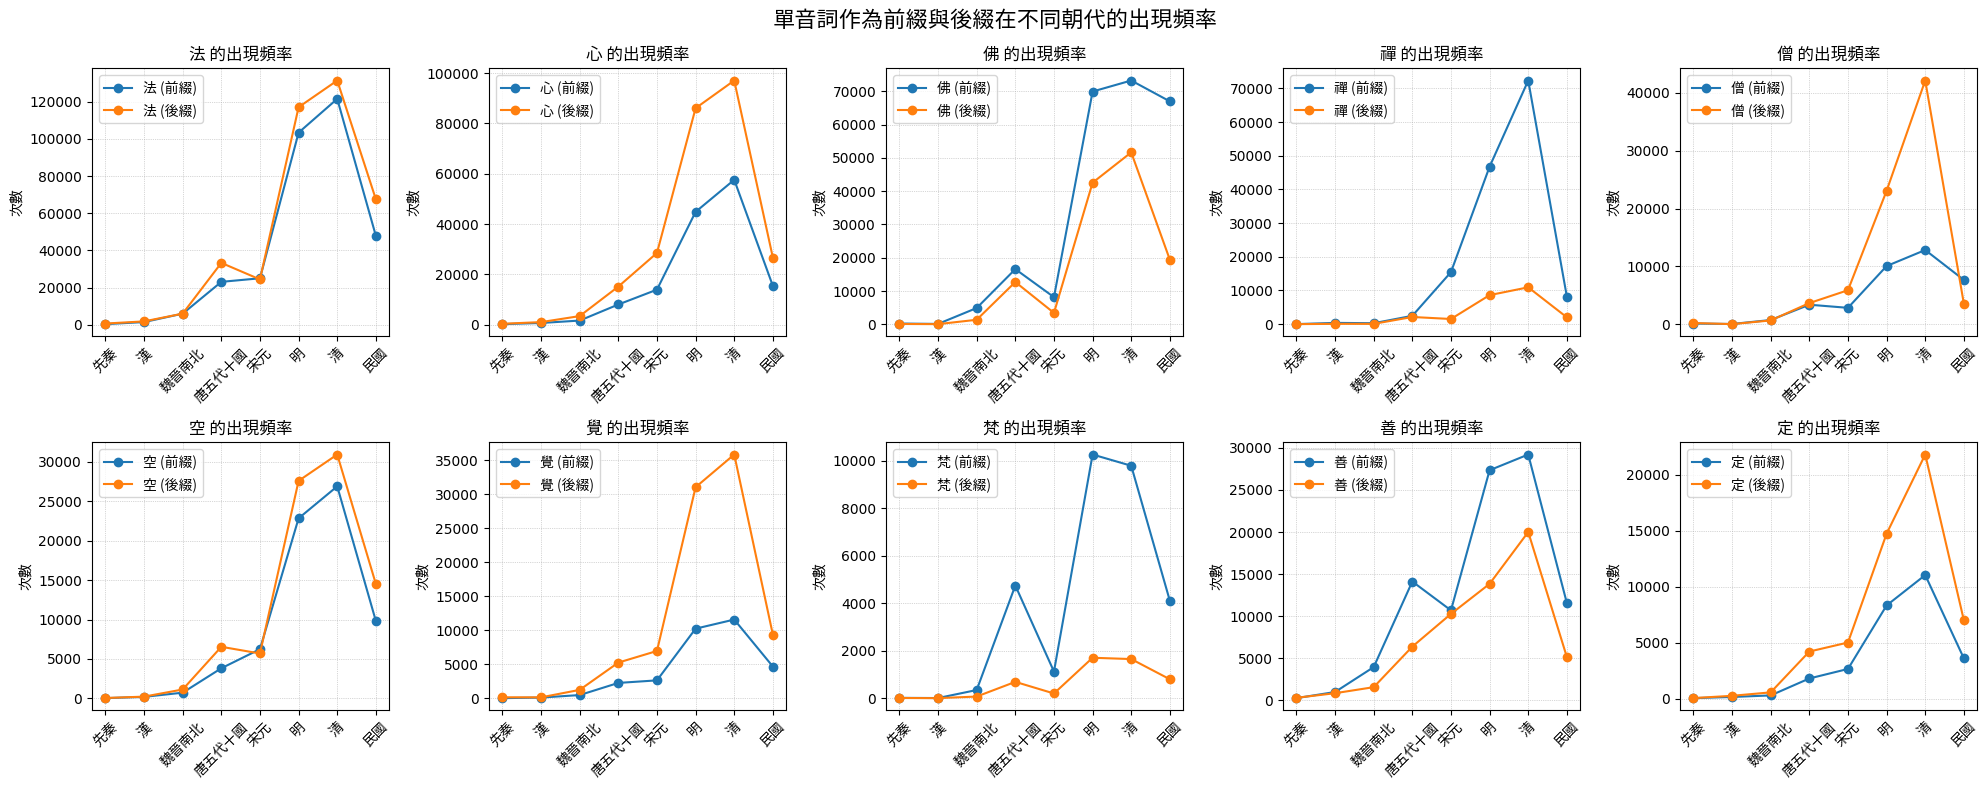

In [15]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# Define the directory for font files
font_dir = "../data/fonts"
font_path = os.path.join(font_dir, "TaipeiSansTCBeta-Regular.ttf")
custom_font = FontProperties(fname=font_path)

# Define the custom dynasty order
dynasty_order = ["先秦", "漢", "魏晉南北", "唐五代十國", "宋元", "明", "清", "民國"]

# Load metadata
metadata_file_path = "../data/processed/hist_corp_contexts.json"
with open(metadata_file_path, "r", encoding="utf-8") as file:
    metadata = json.load(file)

# Top 10 words to analyze
top_10_words = ["法", "心", "佛", "禪", "僧", "空", "覺", "梵", "善", "定"]

# Initialize a dictionary to store results
results = {word: {"prefix": defaultdict(int), "suffix": defaultdict(int)} for word in top_10_words}

# Traverse the metadata and count prefix and suffix occurrences for each word
for bigram, sources in metadata.items():
    for word in top_10_words:
        if bigram.startswith(word):
            position = "prefix"
        elif bigram.endswith(word):
            position = "suffix"
        else:
            continue

        # Count occurrences by dynasty
        for source, records in sources.items():
            for record in records:
                dynasty = record["dynasty"]
                results[word][position][dynasty] += 1

# Plot results for each word
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))  
axes = axes.flatten()  

for i, word in enumerate(top_10_words):
    ax = axes[i]

    # Prepare data for plotting
    prefix_counts = results[word]["prefix"]
    suffix_counts = results[word]["suffix"]
    all_dynasties = sorted(
        set(prefix_counts.keys()).union(suffix_counts.keys()),
        key=lambda x: dynasty_order.index(x) if x in dynasty_order else len(dynasty_order)
    )
    prefix_values = [prefix_counts.get(dynasty, 0) for dynasty in all_dynasties]
    suffix_values = [suffix_counts.get(dynasty, 0) for dynasty in all_dynasties]

    # Plot prefix and suffix counts
    ax.plot(all_dynasties, prefix_values, label=f"{word} (前綴)", marker="o")
    ax.plot(all_dynasties, suffix_values, label=f"{word} (後綴)", marker="o")
    ax.set_title(f"{word} 的出現頻率", fontproperties=custom_font, fontsize=12)
    ax.set_xticks(range(len(all_dynasties)))
    ax.set_xticklabels(all_dynasties, fontproperties=custom_font, rotation=45, fontsize=10)
    ax.set_ylabel("次數", fontproperties=custom_font, fontsize=10)
    ax.grid(True, linestyle=":", linewidth=0.5) 
    ax.legend(prop=custom_font, fontsize=8)

fig.suptitle("單音詞作為前綴與後綴在不同朝代的出現頻率", fontproperties=custom_font, fontsize=16)
plt.tight_layout()
plt.show()

## Realized Productivity

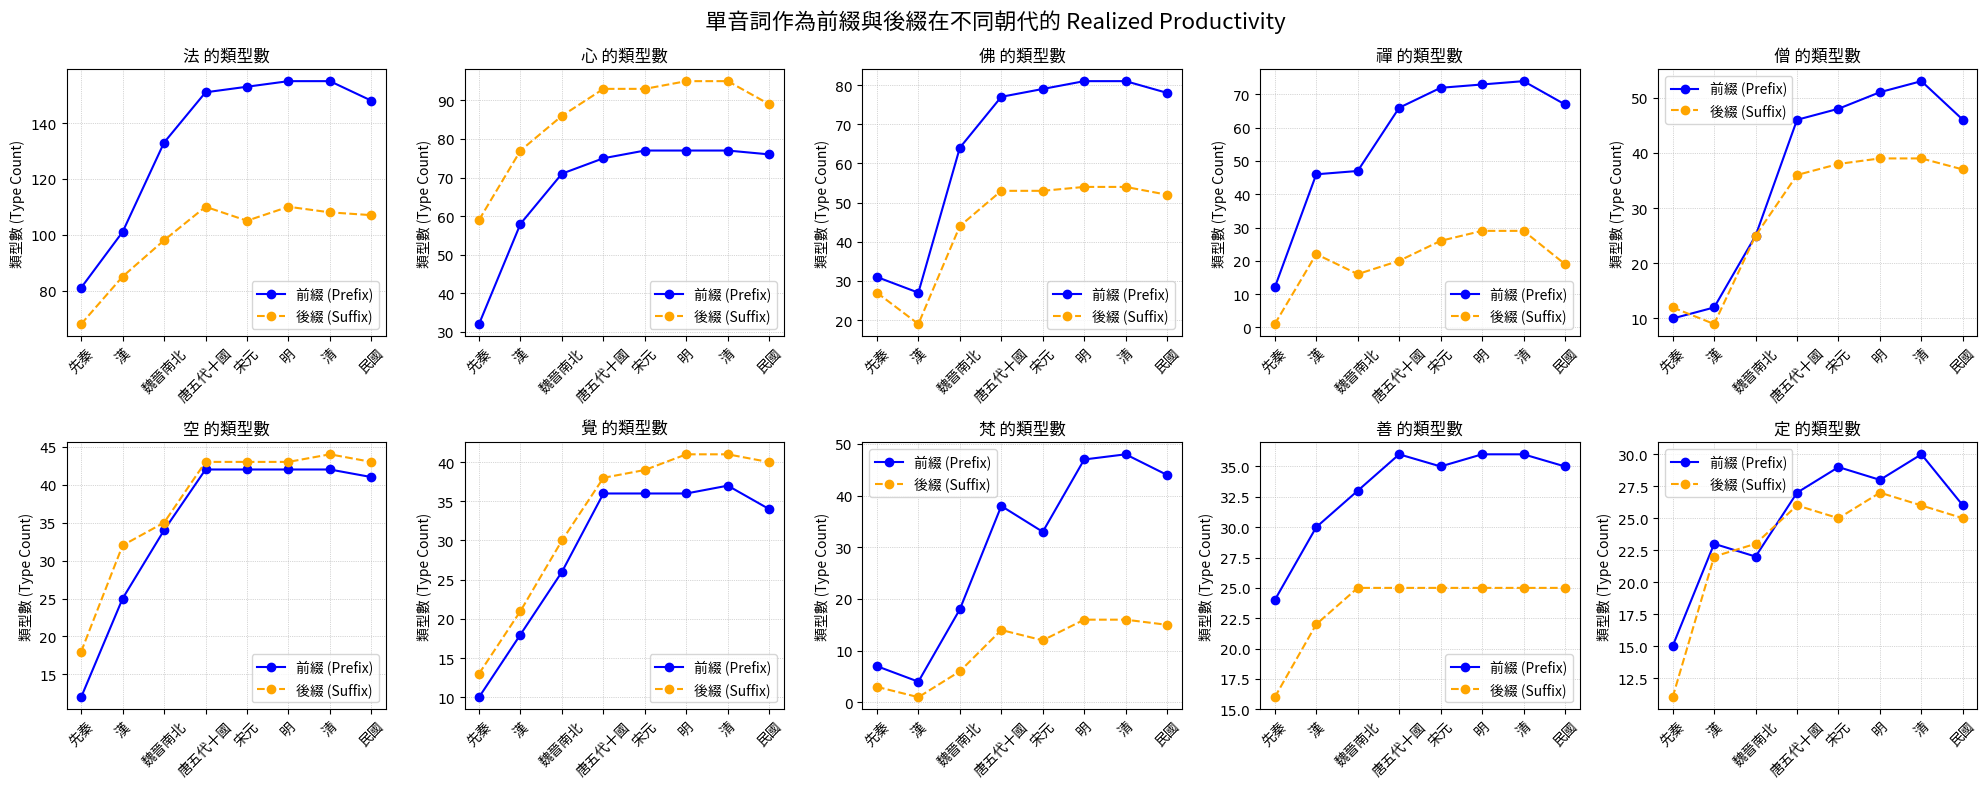

In [18]:
# Initialize results structure
results = {word: {"prefix": defaultdict(set), "suffix": defaultdict(set)} for word in top_10_words}

# Traverse metadata to calculate prefix and suffix type counts
for bigram, sources in metadata.items():
    for word in top_10_words:
        if bigram.startswith(word):
            position = "prefix"
        elif bigram.endswith(word):
            position = "suffix"
        else:
            continue

        # Count unique bigrams by dynasty
        for source, records in sources.items():
            for record in records:
                dynasty = record["dynasty"]
                results[word][position][dynasty].add(bigram)

# Plot results: one subplot per word
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))  
axes = axes.flatten()  

for i, word in enumerate(top_10_words):
    ax = axes[i]

    # Prepare data for plotting
    prefix_counts = {dynasty: len(results[word]["prefix"][dynasty]) for dynasty in dynasty_order}
    suffix_counts = {dynasty: len(results[word]["suffix"][dynasty]) for dynasty in dynasty_order}
    all_dynasties = sorted(
        set(prefix_counts.keys()).union(suffix_counts.keys()),
        key=lambda x: dynasty_order.index(x) if x in dynasty_order else len(dynasty_order)
    )
    prefix_values = [prefix_counts.get(dynasty, 0) for dynasty in all_dynasties]
    suffix_values = [suffix_counts.get(dynasty, 0) for dynasty in all_dynasties]

    # Plot prefix and suffix lines
    ax.plot(all_dynasties, prefix_values, label="前綴 (Prefix)", marker="o", linestyle="-", color="blue")
    ax.plot(all_dynasties, suffix_values, label="後綴 (Suffix)", marker="o", linestyle="--", color="orange")

    # Customize subplot title and labels
    ax.set_title(f"{word} 的類型數", fontproperties=custom_font, fontsize=12)
    ax.set_xticks(range(len(all_dynasties)))
    ax.set_xticklabels(all_dynasties, fontproperties=custom_font, rotation=45, fontsize=10)
    ax.set_ylabel("類型數 (Type Count)", fontproperties=custom_font, fontsize=10)
    ax.grid(True, linestyle=":", linewidth=0.5)
    ax.legend(prop=custom_font, fontsize=8)

fig.suptitle("單音詞作為前綴與後綴在不同朝代的 Realized Productivity", fontproperties=custom_font, fontsize=16)
plt.tight_layout()
plt.show()

## Expanding Productivity

In [19]:
top_10_words = ["法", "心", "佛", "禪", "僧", "空", "覺", "梵", "善", "定"]

hapax_results = {word: {"prefix": [], "suffix": []} for word in top_10_words}

for bigram, sources in metadata.items():
    total_occurrences = sum(len(records) for records in sources.values())

    if total_occurrences == 1:
        for word in top_10_words:
            if bigram.startswith(word):
                hapax_results[word]["prefix"].append(bigram)
            if bigram.endswith(word):
                hapax_results[word]["suffix"].append(bigram)

for word in top_10_words:
    print(f"'{word}' 的 Hapax")
    print(f"  前綴 (Prefix): {hapax_results[word]['prefix']}")
    print(f"  後綴 (Suffix): {hapax_results[word]['suffix']}")

'法' 的 Hapax
  前綴 (Prefix): []
  後綴 (Suffix): []
'心' 的 Hapax
  前綴 (Prefix): []
  後綴 (Suffix): []
'佛' 的 Hapax
  前綴 (Prefix): []
  後綴 (Suffix): []
'禪' 的 Hapax
  前綴 (Prefix): ['禪鎧']
  後綴 (Suffix): []
'僧' 的 Hapax
  前綴 (Prefix): ['僧膳']
  後綴 (Suffix): []
'空' 的 Hapax
  前綴 (Prefix): []
  後綴 (Suffix): []
'覺' 的 Hapax
  前綴 (Prefix): []
  後綴 (Suffix): []
'梵' 的 Hapax
  前綴 (Prefix): []
  後綴 (Suffix): []
'善' 的 Hapax
  前綴 (Prefix): []
  後綴 (Suffix): []
'定' 的 Hapax
  前綴 (Prefix): []
  後綴 (Suffix): []
